# Pairwise Matching
This notebook addresses the questions:
- how often are song-level attributes actually contained in the YouTube metadata?
- how is the fuzzy matching score distributed for these pairs?


In [1]:

import os
import sys
sys.path.append(os.path.abspath('..'))
import pandas as pd

data = pd.read_parquet("/data/csi_datasets/shs100k2_yt.parquet").set_index("yt_id")


### SHS100K 

In [3]:
from src.Matcher import Matcher

def string_match_lower(left_str: str, right_str: str, score_cutoff=None):
    return float(left_str.lower() in right_str.lower())

simple_matcher = Matcher(func=string_match_lower)


left = ["title", "performer"]
right = ["video_title", "channel_name", "description"]

data_simple = simple_matcher.match_pairwise(data, left, right, level="attr")


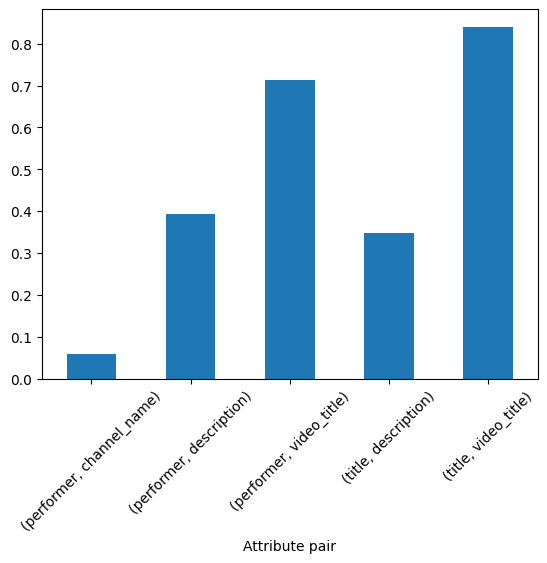

In [6]:
import matplotlib.pyplot as plt

data_simple[[('title', 'video_title'),
                      ('title', 'description'),
                      ('performer', 'video_title'),
                      ('performer', 'description'),
                      ('performer', 'channel_name')]].reset_index().melt(
                          id_vars='yt_id', 
                          var_name='attr_pair', 
                          value_name='Count').groupby(['attr_pair', 'Count']).size().unstack(fill_value=0).apply(
                              lambda x: x[1.0] / (x[0.0] + x[1.0]), axis=1
                          ).plot.bar()

plt.xlabel("Attribute pair")
plt.xticks(rotation=45)
plt.show()


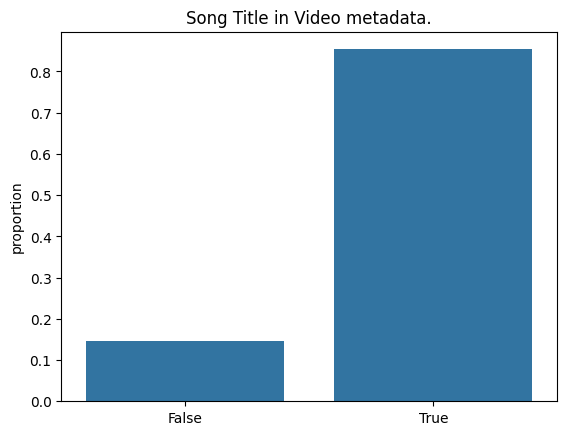

In [7]:
import seaborn as sns

sns.countplot(
    data=data_simple.assign(
        # Song title is either in title or description
        title_in_title_or_description=(
            data_simple[('title', 'video_title')] > 0.5) | 
            (data_simple[('title', 'description')] > 0.5) 
            ),
    x='title_in_title_or_description',
    stat='proportion'
)

plt.title("Song Title in Video metadata.")
plt.xlabel("")
plt.show()



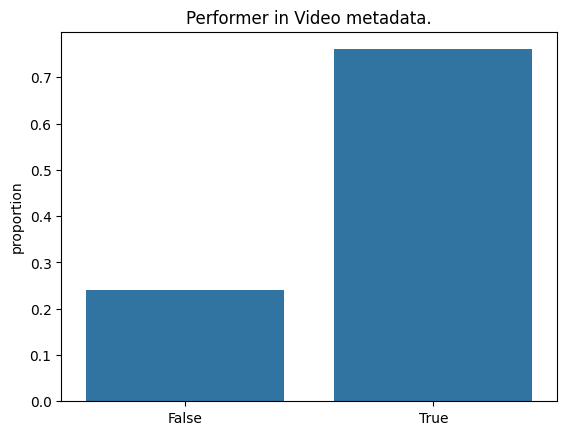

In [8]:
sns.countplot(
    data=data_simple.assign(
        # Song title is either in title or description
        title_in_title_or_description=(
            data_simple[('performer', 'video_title')] > 0.5) | 
            (data_simple[('performer', 'description')] > 0.5) | 
            (data_simple[('performer', 'channel_name')] > 0.5)
            ),
    x='title_in_title_or_description',
    stat='proportion'
)

plt.title("Performer in Video metadata.")
plt.xlabel("")
plt.show()



### Da-Tacos

In [9]:
data = pd.read_parquet("/data/csi_datasets/datacos_yt.parquet").set_index("yt_id")

left = ["title_perf", "title_work", "performer_perf", "performer_work"]
right = ["video_title", "channel_name", "description"]

data_simple = simple_matcher.match_pairwise(data, left, right, level="attr")


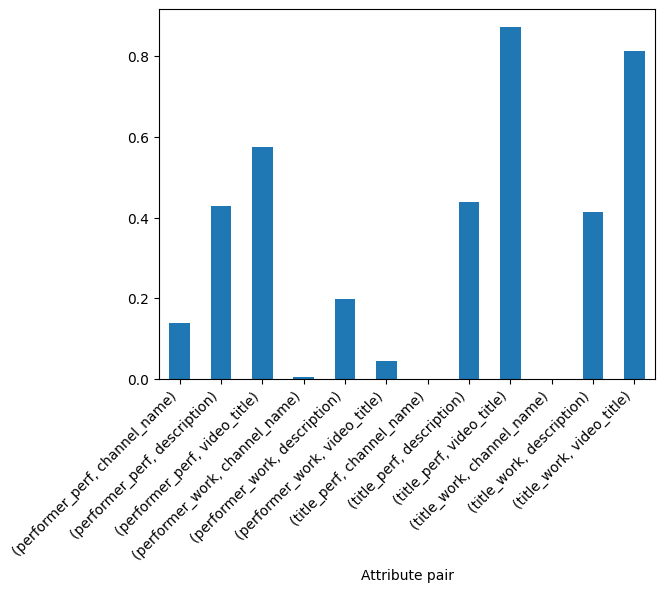

In [10]:
import matplotlib.pyplot as plt

data_simple[[('title_perf', 'video_title'),
            ('title_perf', 'description'),
            ('title_perf', 'channel_name'),
            ('title_work', 'video_title'),
            ('title_work', 'description'),
            ('title_work', 'channel_name'),
            ('performer_perf', 'video_title'),
            ('performer_perf', 'description'),
            ('performer_perf', 'channel_name'),
            ('performer_work', 'video_title'),
            ('performer_work', 'description'),
            ('performer_work', 'channel_name')]].reset_index().melt(
                id_vars='yt_id', 
                          var_name='attr_pair', 
                          value_name='Count').groupby(['attr_pair', 'Count']).size().unstack(fill_value=0).apply(
                              lambda x: x[1.0] / (x[0.0] + x[1.0]), axis=1
                          ).plot.bar(y='Count', x='attr_pair')

plt.xlabel("Attribute pair")
plt.xticks(rotation=45, ha="right")
plt.show()


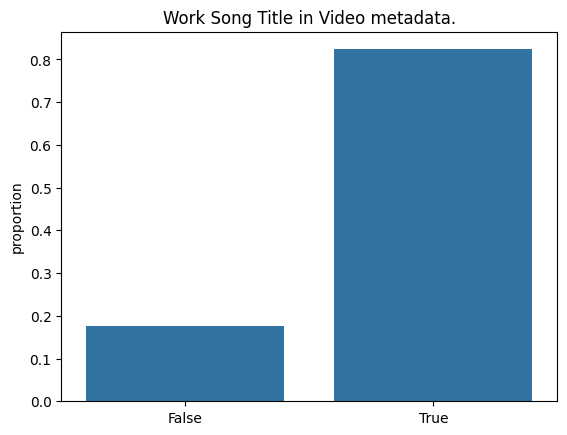

In [11]:
sns.countplot(
    data=data_simple.assign(
        # Song title is either in title or description
        title_in_title_or_description=(
            data_simple[('title_work', 'video_title')] > 0.5) | 
            (data_simple[('title_work', 'description')] > 0.5) | 
            (data_simple[('title_work', 'channel_name')] > 0.5)
            ),
    x='title_in_title_or_description',
    stat='proportion'
)

plt.title("Work Song Title in Video metadata.")
plt.xlabel("")
plt.show()



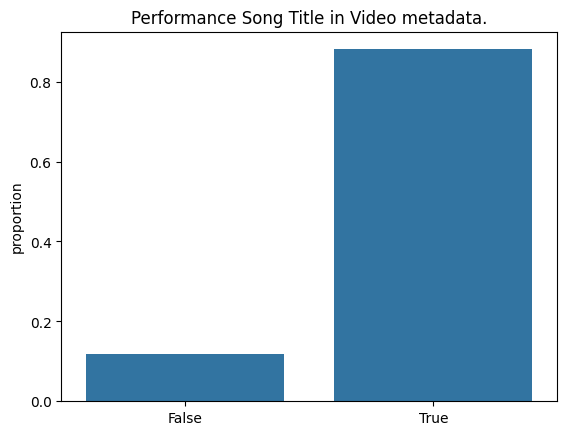

In [12]:
sns.countplot(
    data=data_simple.assign(
        # Song title is either in title or description
        title_in_title_or_description=(
            data_simple[('title_perf', 'video_title')] > 0.5) | 
            (data_simple[('title_perf', 'description')] > 0.5) | 
            (data_simple[('title_perf', 'channel_name')] > 0.5)
            ),
    x='title_in_title_or_description',
    stat='proportion'
)

plt.title("Performance Song Title in Video metadata.")
plt.xlabel("")
plt.show()



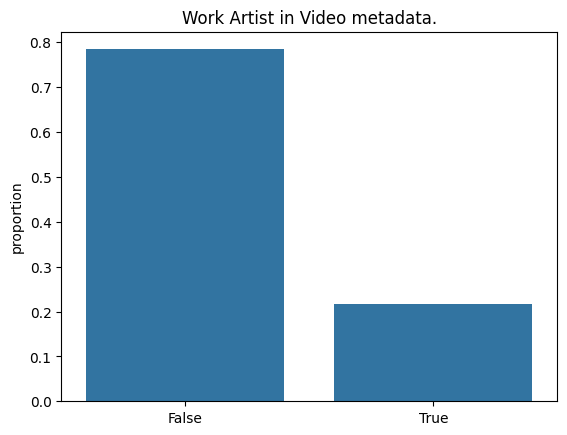

In [13]:
sns.countplot(
    data=data_simple.assign(
        # Song title is either in title or description
        title_in_title_or_description=(
            data_simple[('performer_work', 'video_title')] > 0.5) | 
            (data_simple[('performer_work', 'description')] > 0.5) | 
            (data_simple[('performer_work', 'channel_name')] > 0.5)
            ),
    x='title_in_title_or_description',
    stat='proportion'
)

plt.title("Work Artist in Video metadata.")
plt.xlabel("")
plt.show()



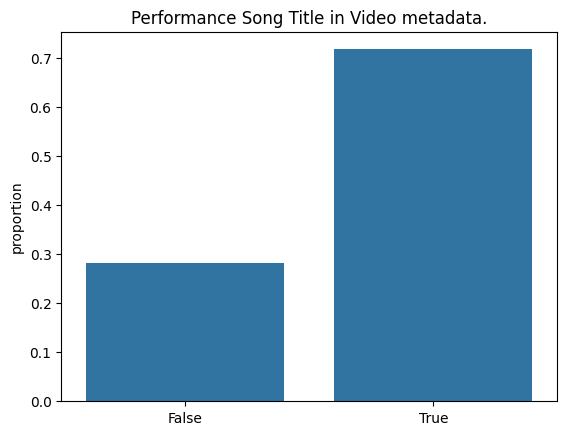

In [14]:
sns.countplot(
    data=data_simple.assign(
        # Song title is either in title or description
        title_in_title_or_description=(
            data_simple[('performer_perf', 'video_title')] > 0.5) | 
            (data_simple[('performer_perf', 'description')] > 0.5) | 
            (data_simple[('performer_perf', 'channel_name')] > 0.5)
            ),
    x='title_in_title_or_description',
    stat='proportion'
)

plt.title("Performance Song Title in Video metadata.")
plt.xlabel("")
plt.show()



# Fuzzy Matching

In [16]:
from src.Matcher import Matcher

fuzzy_matcher = Matcher("fuzz.token_ratio")

left = ["title_perf", "performer_perf", "title_work", "performer_work"]
right = ["video_title", "description"]

data_fuzzy = fuzzy_matcher.match_pairwise(data, left, right, level="attr")


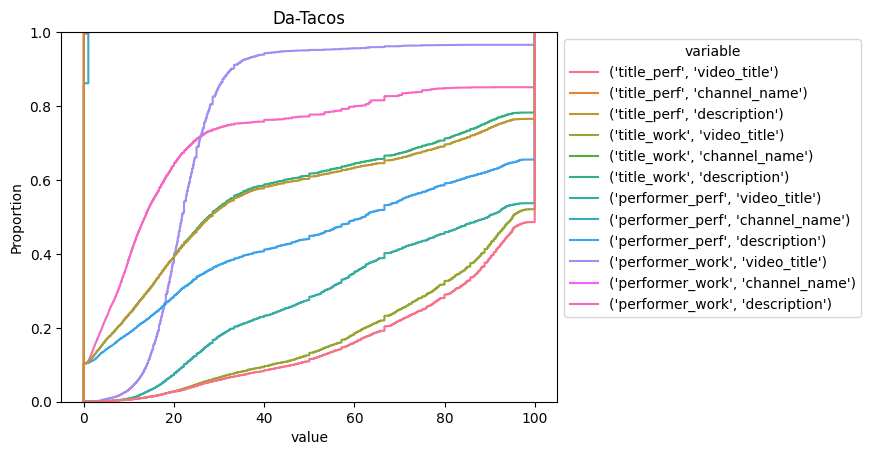

In [17]:
ax = sns.ecdfplot(data=pd.melt(
    data_fuzzy.reset_index(), id_vars=["set_id", "ver_id", "yt_id"], 
    value_vars=[col for col in data_fuzzy.columns if type(col) == tuple]), 
    x="value", hue="variable")

plt.title("Da-Tacos")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()


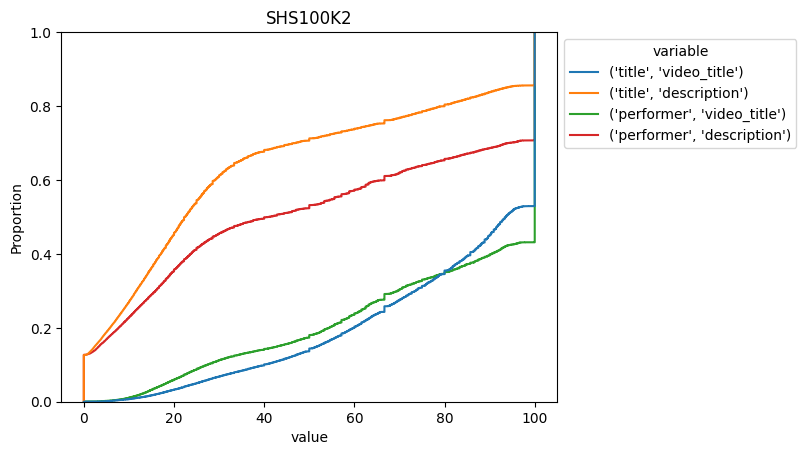

In [18]:
# for SHS100K
data = pd.read_parquet("/data/csi_datasets/shs100k2_yt.parquet").set_index("yt_id")

left = ["title", "performer"]
right = ["video_title", "description"]

data_fuzzy = fuzzy_matcher.match_pairwise(data, left, right, level="attr")


ax = sns.ecdfplot(data=pd.melt(
    data_fuzzy.reset_index(), id_vars=["set_id", "ver_id", "yt_id"], 
    value_vars=[col for col in data_fuzzy.columns if type(col) == tuple]), 
    x="value", hue="variable")

plt.title("SHS100K2")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()
